<a href="https://colab.research.google.com/github/maro9450/SML/blob/main/lab/mnist_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporarily patch this script until the MNIST data set download issue is resolved
# https://github.com/pytorch/vision/issues/1938
import urllib.request
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Classification of hand-written digits

We start by downloading and extracting the MNIST data set.

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.57MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.25MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## The first model
We start by adding five layers to the neural net, while still using the sigmoid function between the hidden layers.

### The model

The input data $X$ are grayscale images of $28\times 28$ pixels. Our model consists of three convolutional layers followed by two dense layers.

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # parameters
        U=[4,8,12]
        U_dense=[200,10]
        self.W1 = nn.Parameter(0.1 * torch.randn(U[0],1,5,5))
        self.b1 = nn.Parameter(torch.ones(U[0])/10)
        self.W2 = nn.Parameter(0.1 * torch.randn(U[1],U[0],5,5))
        self.b2 = nn.Parameter(torch.ones(U[1])/10)
        self.W3 = nn.Parameter(0.1 * torch.randn(U[2],U[1],4,4))
        self.b3 = nn.Parameter(torch.ones(U[2])/10)
        #dense layers
        self.W4 = nn.Parameter(0.1 * torch.randn(U[2]*7*7,U_dense[0]))          #input U[2]x7x7 entries of Q3, output U_dense[0]
        self.b4 = nn.Parameter(torch.ones(U_dense[0])/10)
        self.W5 = nn.Parameter(0.1 * torch.randn(U_dense[0],U_dense[1]))         #input U_dense[0] entries of Q4, output U_dense[1] = 10
        self.b5 = nn.Parameter(torch.ones(U_dense[1])/10)





    def forward(self, X):
        # Hidden convolved layers
        Q1 = F.relu(F.conv2d(X, self.W1, bias=self.b1, stride=1, padding=2))      #size:  n x 4x28x28
        Q2 = F.relu(F.conv2d(Q1, self.W2, bias=self.b2, stride=2, padding=2))     #       n x 8x14x14
        Q3 = F.relu(F.conv2d(Q2, self.W3, bias=self.b3, stride=2, padding=1))     #       n x 12x7x7

        #flatten
        Q3flat = Q3.view(-1, 12*7*7)

        # dense layers
        Q4 = F.relu(Q3flat.mm(self.W4) + self.b4)

        # return the logit
        Z = Q4.mm(self.W5) + self.b5
        return Z

**Answer 4.7:** The convolved hidden layer consists of 12 channels of 7 by 7 grids. Hence the total number of entries are $12 * 7 * 7 = 588$.

### The training

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9).

The next lines evaluate the accuracy of the predictions.

In [4]:
def accuracy(G, Y):
    return (G.argmax(dim=1) == Y).float().mean()

We are ready to train the network.

In [13]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []


# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.003
optimizer = optim.Adam(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 4000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        #now using F.cross_entropy() for loss
        loss = F.cross_entropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(F.cross_entropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy  17.00% train cross-entropy  2.31  test accuracy  14.58% test cross-entropy  2.35
Step   100: train accuracy  88.00% train cross-entropy  0.25  test accuracy  93.41% test cross-entropy  0.22
Step   200: train accuracy  99.00% train cross-entropy  0.05  test accuracy  95.85% test cross-entropy  0.13
Step   300: train accuracy  97.00% train cross-entropy  0.09  test accuracy  97.04% test cross-entropy  0.09
Step   400: train accuracy  97.00% train cross-entropy  0.08  test accuracy  97.26% test cross-entropy  0.09
Step   500: train accuracy  99.00% train cross-entropy  0.02  test accuracy  97.04% test cross-entropy  0.08
Step   600: train accuracy  96.00% train cross-entropy  0.11  test accuracy  97.76% test cross-entropy  0.07
Step   700: train accuracy  97.00% train cross-entropy  0.06  test accuracy  98.28% test cross-entropy  0.05
Step   800: train accuracy 100.00% train cross-entropy  0.01  test accuracy  97.98% test cross-entropy  0.06
Step   900: train a

### The evaluation

The remaining code produces the plots needed to evaluate the training and predictions.

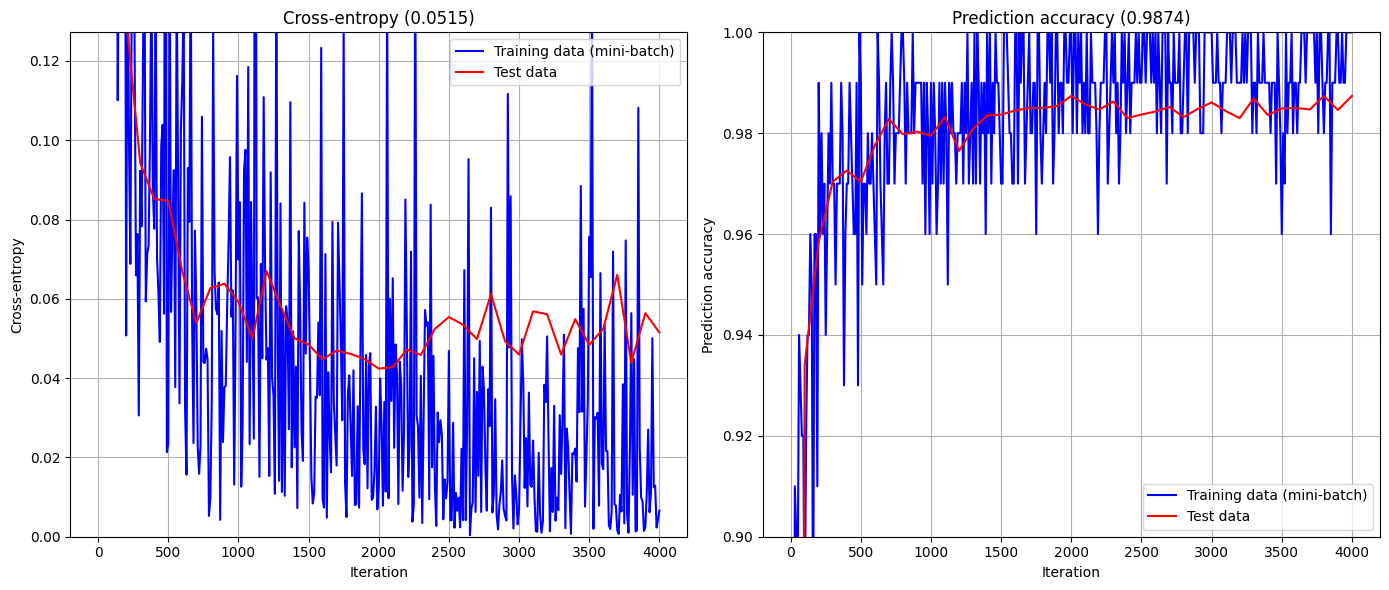

In [14]:
# Set up the 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1st Subplot: Cross-Entropy
axes[0].plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
axes[0].plot(test_iter, test_crossentropy, 'r-', label='Test data')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cross-entropy')
axes[0].set_ylim([0, min(test_crossentropy) * 3])
axes[0].set_title(f'Cross-entropy ({test_crossentropy[-1]:1.4f})')
axes[0].grid(True)
axes[0].legend(loc='best')

# 2nd Subplot: Prediction Accuracy
axes[1].plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
axes[1].plot(test_iter, test_accuracy, 'r-', label='Test data')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Prediction accuracy')
axes[1].set_ylim([0.9, 1])
axes[1].set_title(f'Prediction accuracy ({test_accuracy[-1]:1.4f})')
axes[1].grid(True)
axes[1].legend(loc='best')

# Adjust layout for readability
plt.tight_layout()
plt.show()

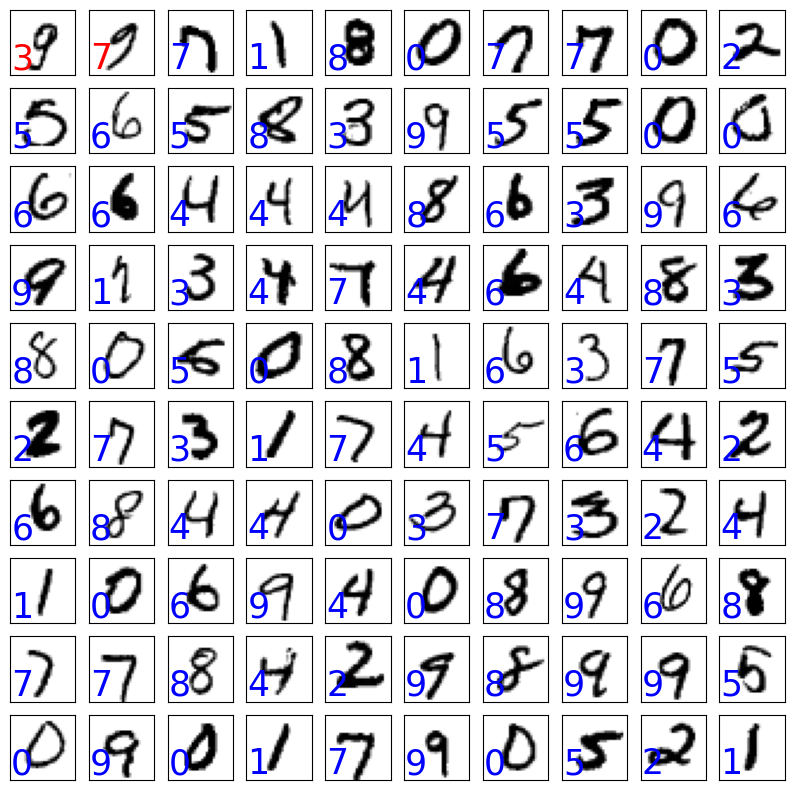

In [15]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))

    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)

    # compute the predictions for the sampled inputs
    random_G = net(random_X)
    random_Yhat = random_G.argmax(dim=1)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])

    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)

    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)

plt.show()

## Updating learning rate

In [16]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []


# initialize the neural network and move it to the GPU if needed
net = Net()
net.to(device)

# define the optimization algorithm
learningrate = 0.003
optimizer = optim.Adam(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)


# Define the minimum and maximum learning rates
gamma_min = 0.0001  # Minimum learning rate
gamma_max = 0.003   # Initial maximum learning rate


# perform multiple training steps
total_iterations = 6000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # Update the learning rate based on the formula
        gamma_new = gamma_min + (gamma_max - gamma_min) * torch.exp(torch.tensor(-t / 2000.0))
        for p in optimizer.param_groups:
            p['lr'] = gamma_new.item()  # Update the learning rate in the optimizer

        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        #now using F.cross_entropy() for loss
        loss = F.cross_entropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(F.cross_entropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy  11.00% train cross-entropy  2.40  test accuracy   9.58% test cross-entropy  2.57
Step   100: train accuracy  92.00% train cross-entropy  0.25  test accuracy  94.04% test cross-entropy  0.19
Step   200: train accuracy  97.00% train cross-entropy  0.07  test accuracy  96.13% test cross-entropy  0.12
Step   300: train accuracy  97.00% train cross-entropy  0.14  test accuracy  97.04% test cross-entropy  0.09
Step   400: train accuracy  99.00% train cross-entropy  0.03  test accuracy  97.61% test cross-entropy  0.07
Step   500: train accuracy  97.00% train cross-entropy  0.09  test accuracy  97.61% test cross-entropy  0.08
Step   600: train accuracy  98.00% train cross-entropy  0.08  test accuracy  98.17% test cross-entropy  0.06
Step   700: train accuracy  98.00% train cross-entropy  0.06  test accuracy  97.81% test cross-entropy  0.06
Step   800: train accuracy  97.00% train cross-entropy  0.12  test accuracy  98.52% test cross-entropy  0.05
Step   900: train a

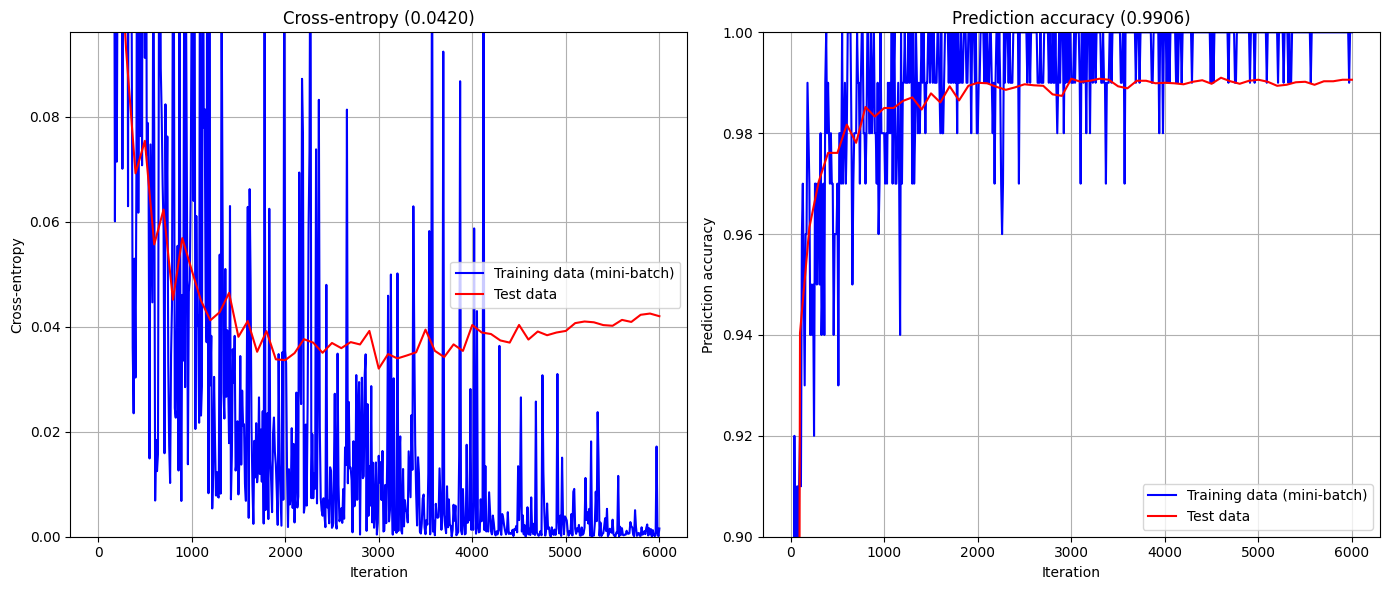

In [17]:
# Set up the 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1st Subplot: Cross-Entropy
axes[0].plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
axes[0].plot(test_iter, test_crossentropy, 'r-', label='Test data')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cross-entropy')
axes[0].set_ylim([0, min(test_crossentropy) * 3])
axes[0].set_title(f'Cross-entropy ({test_crossentropy[-1]:1.4f})')
axes[0].grid(True)
axes[0].legend(loc='best')

# 2nd Subplot: Prediction Accuracy
axes[1].plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
axes[1].plot(test_iter, test_accuracy, 'r-', label='Test data')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Prediction accuracy')
axes[1].set_ylim([0.9, 1])
axes[1].set_title(f'Prediction accuracy ({test_accuracy[-1]:1.4f})')
axes[1].grid(True)
axes[1].legend(loc='best')

# Adjust layout for readability
plt.tight_layout()
plt.show()

**Answer 4.10:** Training accuracy is often 100%, indicating it has memorized the training data.